# Synthetic sanity checks for Surprise models

This notebook runs small, controlled experiments to verify expected *ranking shifts* as we change data knobs.
We are not trying to crown a single winner, just to see the direction of change.


In [1]:
import sys
from pathlib import Path

ROOT = Path.cwd().resolve()
if (ROOT / 'src').exists():
    sys.path.insert(0, str(ROOT))
elif (ROOT.parent / 'src').exists():
    sys.path.insert(0, str(ROOT.parent))


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from surprise import Dataset, Reader, accuracy
from surprise import BaselineOnly, KNNBasic, SVD, SVDpp
from surprise.model_selection import train_test_split

from cluster_simulation import generate_mask_zipf_global, fill_ratings_clusters


In [ ]:
def make_synthetic(
    U=943,
    I=1682,
    density=0.05,
    alpha_user=0.9,
    alpha_item=0.9,
    seed=42,
    sigma_eps=0.4,
    sigma_bu=0.5,
    sigma_bi=0.5,
    gamma=0.4,
    beta=1.0,
    n_user_clusters=12,
    n_item_clusters=18,
):
    pairs, uc, ic, A = generate_mask_zipf_global(
        U,
        I,
        density=density,
        alpha_user=alpha_user,
        alpha_item=alpha_item,
        seed=seed,
        min_user_ratings=20,
        min_item_ratings=5,
        n_user_clusters=n_user_clusters,
        n_item_clusters=n_item_clusters,
        beta=beta,
        return_clusters=True,
    )

    R_syn = fill_ratings_clusters(
        U=U,
        I=I,
        pairs=pairs,
        user_cluster=uc,
        item_cluster=ic,
        tau=np.array([-1.2, -0.4, 0.4, 1.2]),
        seed=seed,
        mu=0.4,
        sigma_bu=sigma_bu,
        sigma_bi=sigma_bi,
        sigma_eps=sigma_eps,
        gamma=gamma,
        A=A,
    )

    ratings_long = pd.DataFrame(R_syn).stack().reset_index()
    ratings_long.columns = ["UserID", "MovieID", "Rating"]
    return ratings_long


def get_models():
    return {
        "BaselineOnly": BaselineOnly(verbose=False),
        "KNNBasic": KNNBasic(
            sim_options={"name": "pearson_baseline", "user_based": True},
            verbose=False,
        ),
        "SVD": SVD(random_state=42, verbose=False),
        "SVDpp": SVDpp(random_state=42, verbose=False),
    }


def eval_models(df, train_frac=0.8, seed=42):
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(df[["UserID", "MovieID", "Rating"]], reader)
    trainset, testset = train_test_split(
        data, test_size=(1 - train_frac), random_state=seed
    )

    rows = []
    for name, algo in get_models().items():
        algo.fit(trainset)
        preds = algo.test(testset)
        rmse = accuracy.rmse(preds, verbose=False)
        rows.append({"Model": name, "RMSE": float(rmse)})

    return pd.DataFrame(rows)


## Item-wise rating sums (linear and log-log)


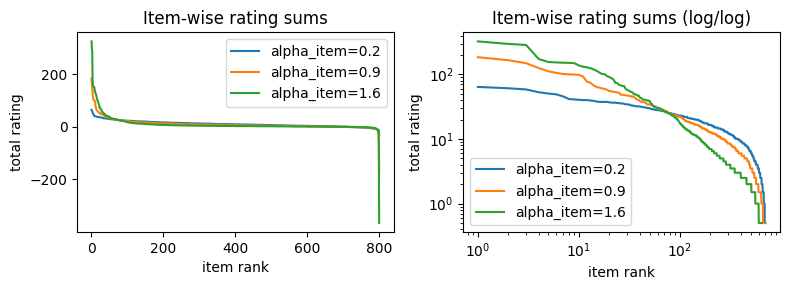

In [13]:
# Compare item popularity shape across alpha_item values
alpha_items = [0.2, 0.9, 1.6]
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

for a in alpha_items:
    df = make_synthetic(seed=42, alpha_item=a)
    df = df.copy()
    df["Rating"] = (df["Rating"] - 3.0) / 2.0

    item_sums = df.groupby("MovieID")["Rating"].sum().sort_values(ascending=False)
    axes[0].plot(np.arange(1, len(item_sums) + 1), item_sums.values, label=f"alpha_item={a}")

    item_pos = item_sums[item_sums > 0]
    axes[1].plot(np.arange(1, len(item_pos) + 1), item_pos.values, label=f"alpha_item={a}")

axes[0].set_title("Item-wise rating sums")
axes[0].set_xlabel("item rank")
axes[0].set_ylabel("total rating")
axes[0].legend()

axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_title("Item-wise rating sums (log/log)")
axes[1].set_xlabel("item rank")
axes[1].set_ylabel("total rating")
axes[1].legend()

plt.tight_layout()
plt.show()


## 1) Learning curves (train fraction ? => test RMSE ?)
We average over a few seeds to smooth noise.


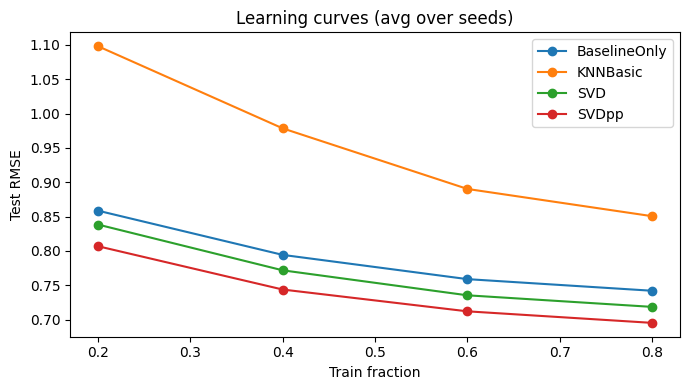

In [5]:
fractions = [0.2, 0.4, 0.6, 0.8]
seeds = [0, 1, 2]

base_df = make_synthetic(seed=42)
curve_rows = []
for frac in fractions:
    for s in seeds:
        res = eval_models(base_df, train_frac=frac, seed=s)
        res["TrainFrac"] = frac
        curve_rows.append(res)

curve_df = pd.concat(curve_rows, ignore_index=True)
curve_mean = (
    curve_df.groupby(["Model", "TrainFrac"], as_index=False)["RMSE"]
    .mean()
)

plt.figure(figsize=(7, 4))
for model in curve_mean["Model"].unique():
    subset = curve_mean[curve_mean["Model"] == model]
    plt.plot(subset["TrainFrac"], subset["RMSE"], marker="o", label=model)
plt.title("Learning curves (avg over seeds)")
plt.xlabel("Train fraction")
plt.ylabel("Test RMSE")
plt.legend()
plt.tight_layout()
plt.show()


## 2) Noise knob (sigma_eps ? => RMSE ?)


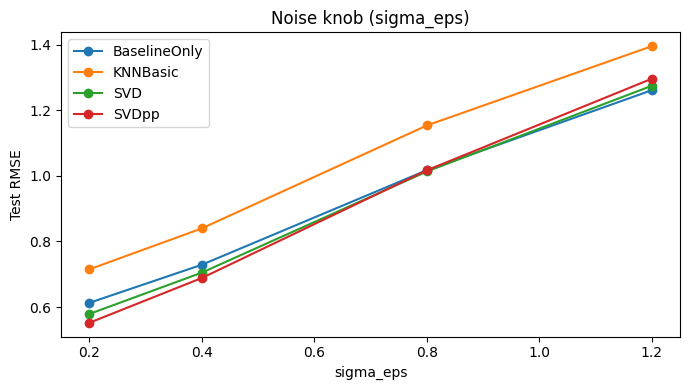

In [6]:
sigmas = [0.2, 0.4, 0.8, 1.2]
rows = []
for s in sigmas:
    df = make_synthetic(seed=42, sigma_eps=s)
    res = eval_models(df, train_frac=0.8, seed=42)
    res["sigma_eps"] = s
    rows.append(res)

noise_df = pd.concat(rows, ignore_index=True)
plt.figure(figsize=(7, 4))
for model in noise_df["Model"].unique():
    subset = noise_df[noise_df["Model"] == model]
    plt.plot(subset["sigma_eps"], subset["RMSE"], marker="o", label=model)
plt.title("Noise knob (sigma_eps)")
plt.xlabel("sigma_eps")
plt.ylabel("Test RMSE")
plt.legend()
plt.tight_layout()
plt.show()


## 3) Sparsity knob (lower density hurts KNN more than MF)


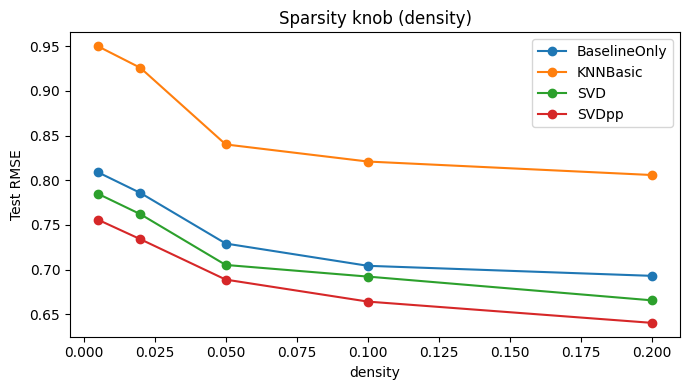

In [7]:
densities = [0.005, 0.02, 0.05, 0.1, 0.2]
rows = []
for d in densities:
    df = make_synthetic(seed=42, density=d)
    res = eval_models(df, train_frac=0.8, seed=42)
    res["density"] = d
    rows.append(res)

dens_df = pd.concat(rows, ignore_index=True)
plt.figure(figsize=(7, 4))
for model in dens_df["Model"].unique():
    subset = dens_df[dens_df["Model"] == model]
    plt.plot(subset["density"], subset["RMSE"], marker="o", label=model)
plt.title("Sparsity knob (density)")
plt.xlabel("density")
plt.ylabel("Test RMSE")
plt.legend()
plt.tight_layout()
plt.show()


## 4) Popularity knob (item bias dominates => BaselineOnly stronger)


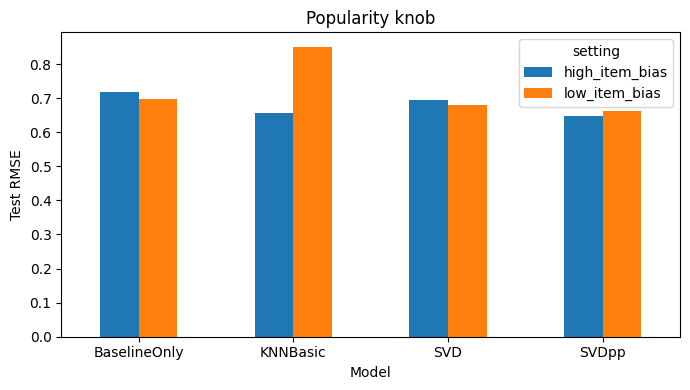

setting,high_item_bias,low_item_bias
Model,,
BaselineOnly,0.718647,0.698684
KNNBasic,0.656770,0.850775
SVD,0.693418,0.680788
SVDpp,0.648661,0.661491


In [21]:
settings = [
    {"label": "low_item_bias", "sigma_bi": 0.5, "sigma_bu": 0.5, "gamma": 0.4},
    {"label": "high_item_bias", "sigma_bi": 1, "sigma_bu": 0, "gamma": .4},
]
rows = []
for cfg in settings:
    df = make_synthetic(
        seed=3,
        sigma_bi=cfg["sigma_bi"],
        sigma_bu=cfg["sigma_bu"],
        gamma=cfg["gamma"],
    )
    res = eval_models(df, train_frac=0.8, seed=42)
    res["setting"] = cfg["label"]
    rows.append(res)

pop_df = pd.concat(rows, ignore_index=True)
pivot = pop_df.pivot(index="Model", columns="setting", values="RMSE")
pivot.plot(kind="bar", figsize=(7, 4), rot=0, title="Popularity knob")
plt.ylabel("Test RMSE")
plt.tight_layout()
plt.show()
pivot


If any trend looks noisy, increase U/I or average over more seeds.
